<a href="https://colab.research.google.com/github/estebanegm/PINN_example/blob/main/PINN__example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se resuelve la siguiente ecuación diferencial:
\begin{align}
\frac{du}{dt} = \cos2\pi t
\end{align}

*   Condición inicial:
\begin{align}
u(0) = 1
\end{align}

*   Condición inicial:
\begin{align}
u(0) = 1
\end{align}

*   Se hace una red neuronal y función de pérdida como la siguiente:
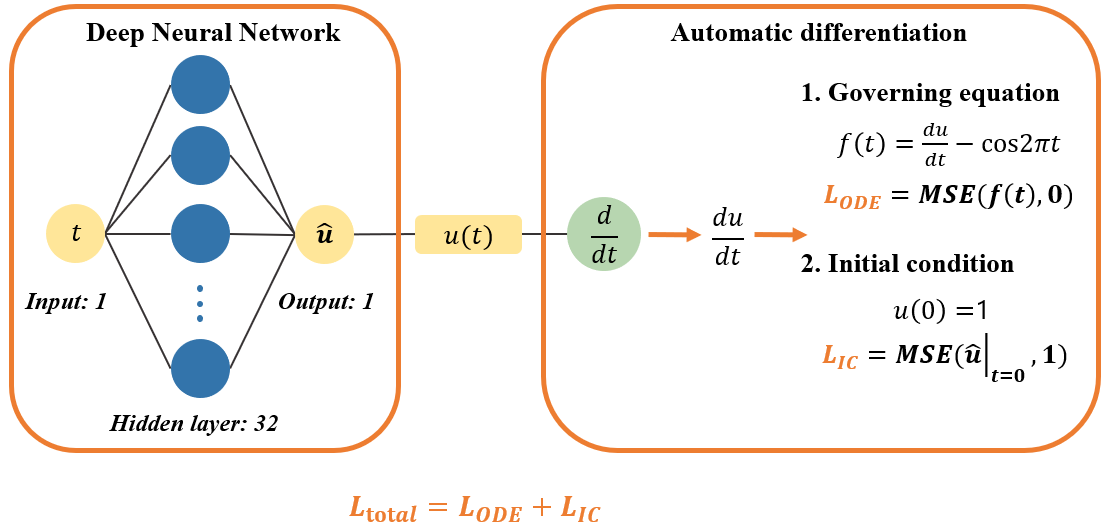





In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

Se define la red neuronal y sus hiperparametros

In [3]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

Se define el sistema de ecuaciones diferenciales ordinarias (ODE System)


*   ODE LOSS:

\begin{align}
L_{\text{ODE}} = \frac{1}{n}\sum_{i=1}^{n} \left(\frac{d \text{NN}(t_i)}{dt}- \cos2\pi t_i\right)^2
\end{align}

*   Initial Condition LOSS:
\begin{align}
L_{IC} = \frac{1}{n}\sum_{i=1}^{n} \left({\text{NN}(0)}- 1\right)^2
\end{align}

*   Total LOSS:
\begin{align}
L_{\text{Total}} = L_{\text{ODE}} + L_{\text{IC}}
\end{align}


In [5]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

Se entrena la red neuronal y se hace la predicción

1.5287884
0.44554383
0.2204093
0.07543898
0.012594956
0.00093666196


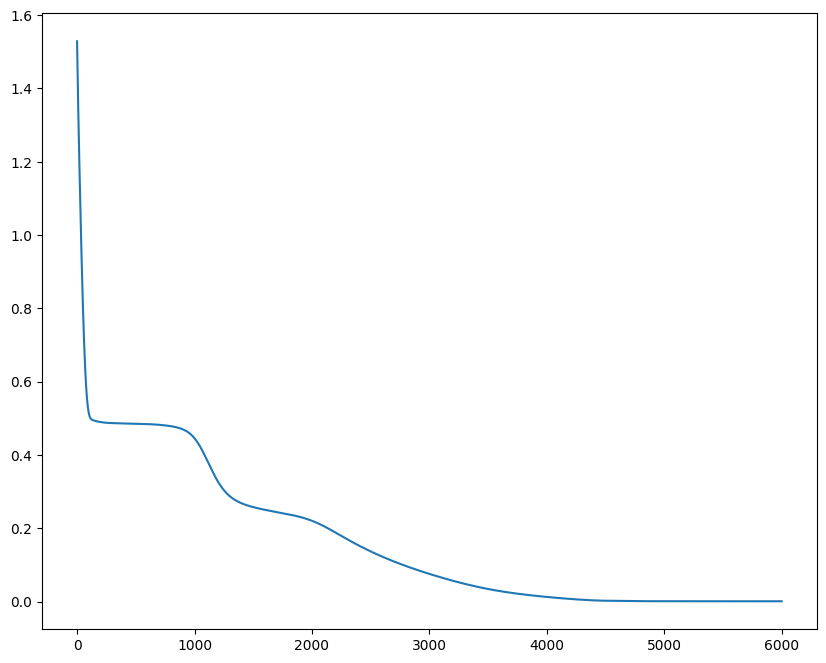

In [6]:
train_t = (np.random.rand(30)*2).reshape(-1, 1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

4/4 [==============================] - 0s 6ms/step


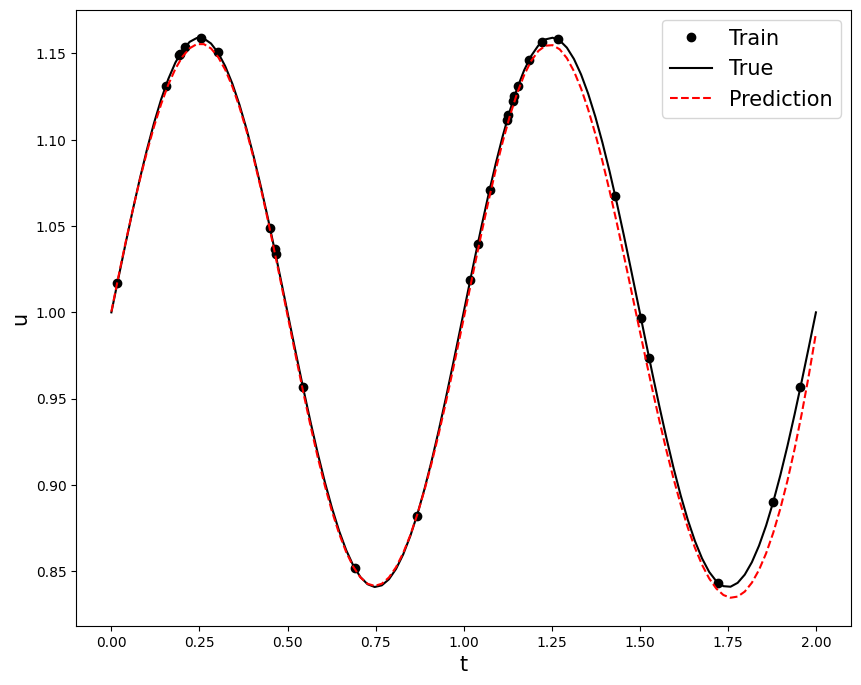

In [9]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()